In [14]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Quick data visualization

First let's see how our images look like:

📂 Classes détectées : ['train', 'test']


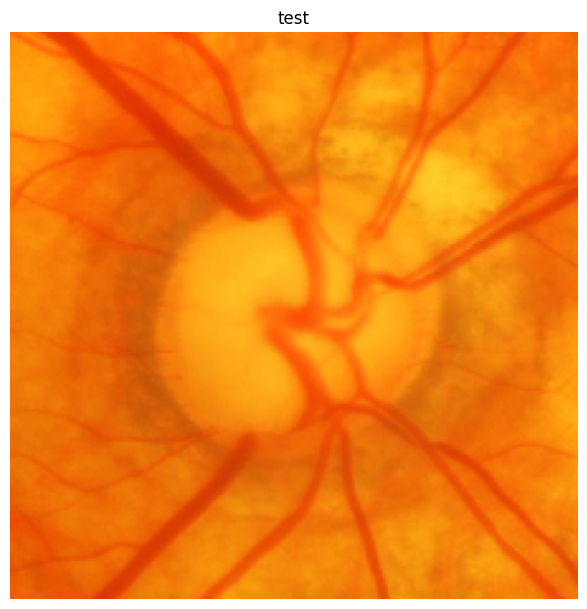

In [15]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img


base_path = "/content/drive/My Drive/acrima"


classes = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]


if not classes:
    print("❌ Aucun sous-dossier trouvé, vérifiez le dataset.")
else:
    print(f"📂 Classes détectées : {classes}")

    plt.figure(figsize=(12, 6))
    images_found = 0

    # Afficher une image par classe
    for i, class_name in enumerate(classes):
        images_path = os.path.join(base_path, class_name)  # Prendre uniquement les images
        if not os.path.exists(images_path):
            print(f"⚠ Pas de dossier 'images' trouvé pour {class_name}")
            continue

        # Lister les fichiers images
        image_files = [f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        if image_files:
            img_path = os.path.join(images_path, image_files[0])
            img = load_img(img_path, target_size=(224, 224))

            plt.subplot(1, len(classes), images_found + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")

            images_found += 1

    if images_found > 0:
        plt.tight_layout()
        plt.show()
    else:
        print("❌ Aucune image trouvée dans les classes.")


In [16]:

for expression in os.listdir(base_path + "/train"):
    print(str(len(os.listdir(base_path+ "/train/" + expression))) + " " + expression + " images")

239 Non Glaucoma images
326 Glaucoma images


In [17]:

import os
import pandas as pd
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 📂 Chemin du dossier d'entraînement
train_dir = "/content/drive/My Drive/acrima/train"

classes = os.listdir(train_dir)
data = []

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    images = [
        os.path.join(class_name, img)
        for img in os.listdir(class_path)
        if img.endswith(('png', 'jpg', 'jpeg'))
    ]
    data.extend([(img, class_name) for img in images])


df = pd.DataFrame(data, columns=["filename", "class"])


min_samples = df['class'].value_counts().min()
df_balanced = df.groupby('class', group_keys=False).apply(lambda x: x.sample(min_samples, random_state=42))


pic_size = 224
batch_size = 32


datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_dataframe(
    df_balanced,
    directory=train_dir,
    x_col='filename',
    y_col='class',
    target_size=(pic_size, pic_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)


print("📊 Nouvelle distribution des classes :\n", df_balanced['class'].value_counts())


Found 478 validated image filenames belonging to 2 classes.
📊 Nouvelle distribution des classes :
 class
Glaucoma        239
Non Glaucoma    239
Name: count, dtype: int64


<ipython-input-17-eaed69ba74d9>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('class', group_keys=False).apply(lambda x: x.sample(min_samples, random_state=42))


The image expressions in our training dataset are pretty balanced, except for the 'disgust' category.

Deep learning models are trained by being fed with batches of data. Keras has a very useful class to automatically feed data from a directory: ImageDataGenerator.

It can also perform data augmentation while getting the images (randomly rotating the image, zooming, etc.). This method is often used as a way to artificially get more data when the dataset has a small size.

The function flow_from_directory() specifies how the generator should import the images (path, image size, colors, etc.).


In [18]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


local_weights_path = "imagenet"
IMG_SHAPE = (224, 224, 3)


from tensorflow.keras.applications import MobileNetV2


baseModel = MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights=local_weights_path
)


print("Number of layers in the base model: ", len(baseModel.layers))

Number of layers in the base model:  154


In [27]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
def create_model():

    for layer in baseModel.layers[:152]:
        layer.trainable = False
    for layer in baseModel.layers[152:]:
        layer.trainable = True


    model = models.Sequential([
        baseModel,
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.6),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.6),
        layers.Dense(1, activation='sigmoid')
    ])


    # Compilation
    model.compile(optimizer=Adam(learning_rate=5e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [20]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-3,
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)

In [21]:
def balance_dataframe(df, label_col='class'):
    min_size = df[label_col].value_counts().min()
    balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
    return balanced_df

In [28]:
model=create_model()
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 7, 7, 128)      │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,273 (9.27 MB)

 Trainable params: 174,849 (683.00 KB)

 Non-trainable params: 2,255,424 (8.60 MB)

Fold 1/5
Found 382 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 915ms/step - accuracy: 0.5325 - loss: 0.8301 - val_accuracy: 0.5208 - val_loss: 0.6793
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - accuracy: 0.5696 - loss: 0.7469 - val_accuracy: 0.6250 - val_loss: 0.6513
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.6253 - loss: 0.6517 - val_accuracy: 0.6771 - val_loss: 0.6236
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.6503 - loss: 0.6282 - val_accuracy: 0.6875 - val_loss: 0.6002
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.6376 - loss: 0.6143 - val_accuracy: 0.7292 - val_loss: 0.5817
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.6663 - loss: 0.5788 - val_accuracy: 0.7396 - val_loss: 0.5657
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step - accuracy: 0.6499 - loss: 0.6066 - val_accuracy: 0.7500 - val_loss: 0.5533
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 318ms/step - accuracy: 0.6806 - loss: 0.5973 - val_acc

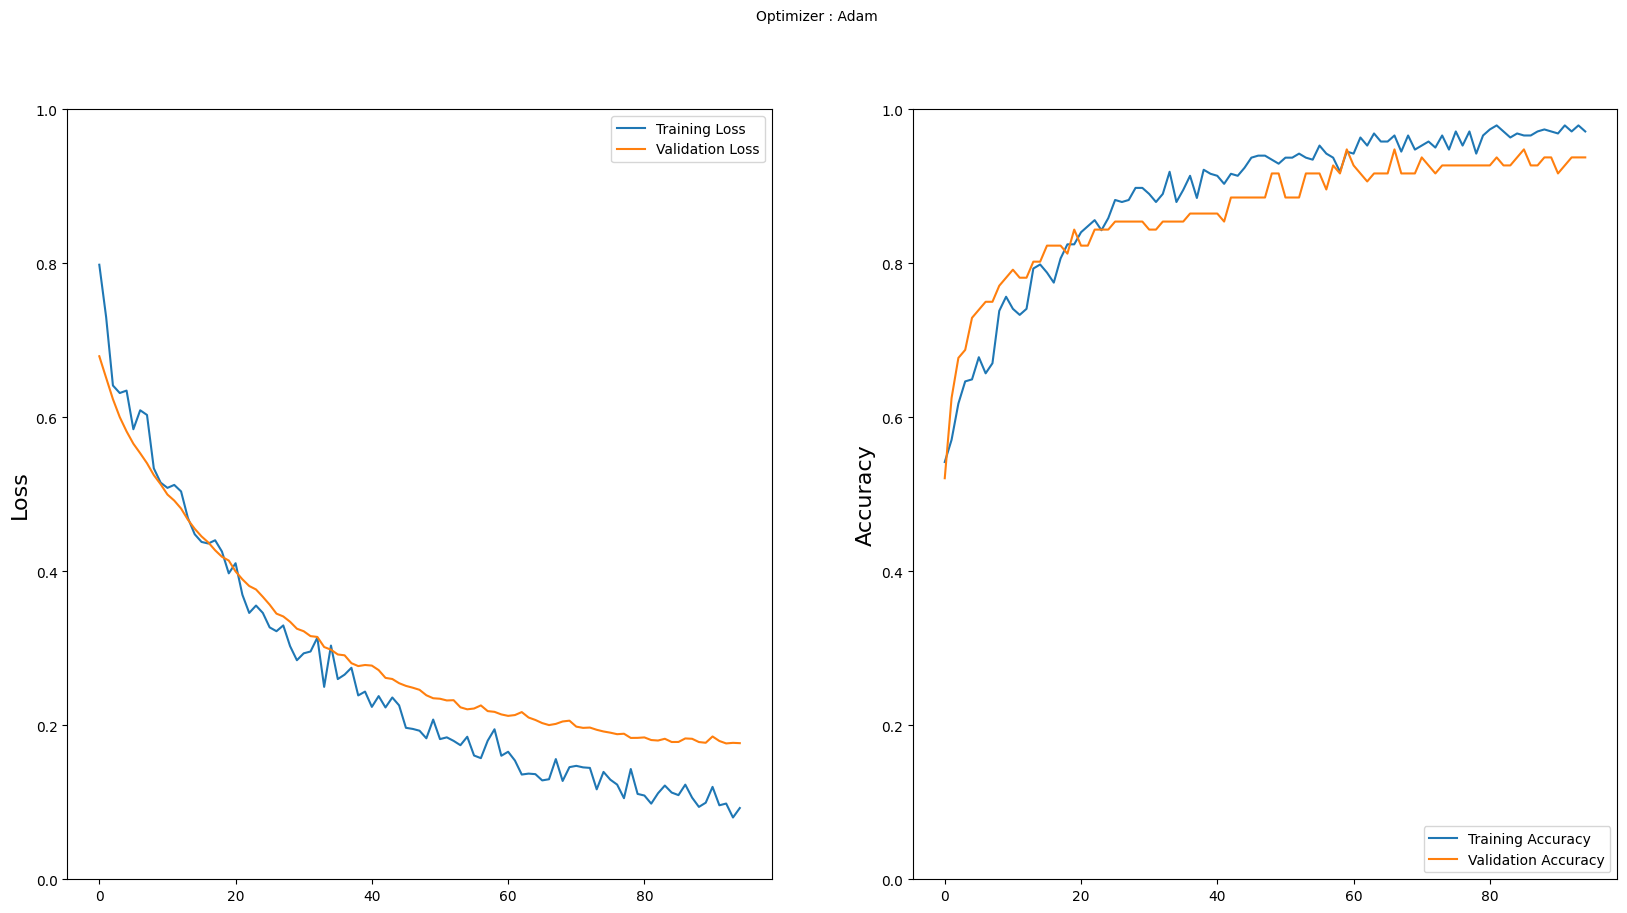

Fold 2/5
Found 382 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 914ms/step - accuracy: 0.5281 - loss: 0.8609 - val_accuracy: 0.5729 - val_loss: 0.6777
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.5175 - loss: 0.7810 - val_accuracy: 0.5417 - val_loss: 0.6617
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - accuracy: 0.6310 - loss: 0.6615 - val_accuracy: 0.6146 - val_loss: 0.6357
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.6177 - loss: 0.6754 - val_accuracy: 0.6667 - val_loss: 0.6049
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.6558 - loss: 0.6161 - val_accuracy: 0.7292 - val_loss: 0.5782
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.6689 - loss: 0.6118 - val_accuracy: 0.7812 - val_loss: 0.5584
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.7132 - loss: 0.5600 - val_accuracy: 0.7917 - val_loss: 0.5390
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.7338 - loss: 0.5574 - val_acc

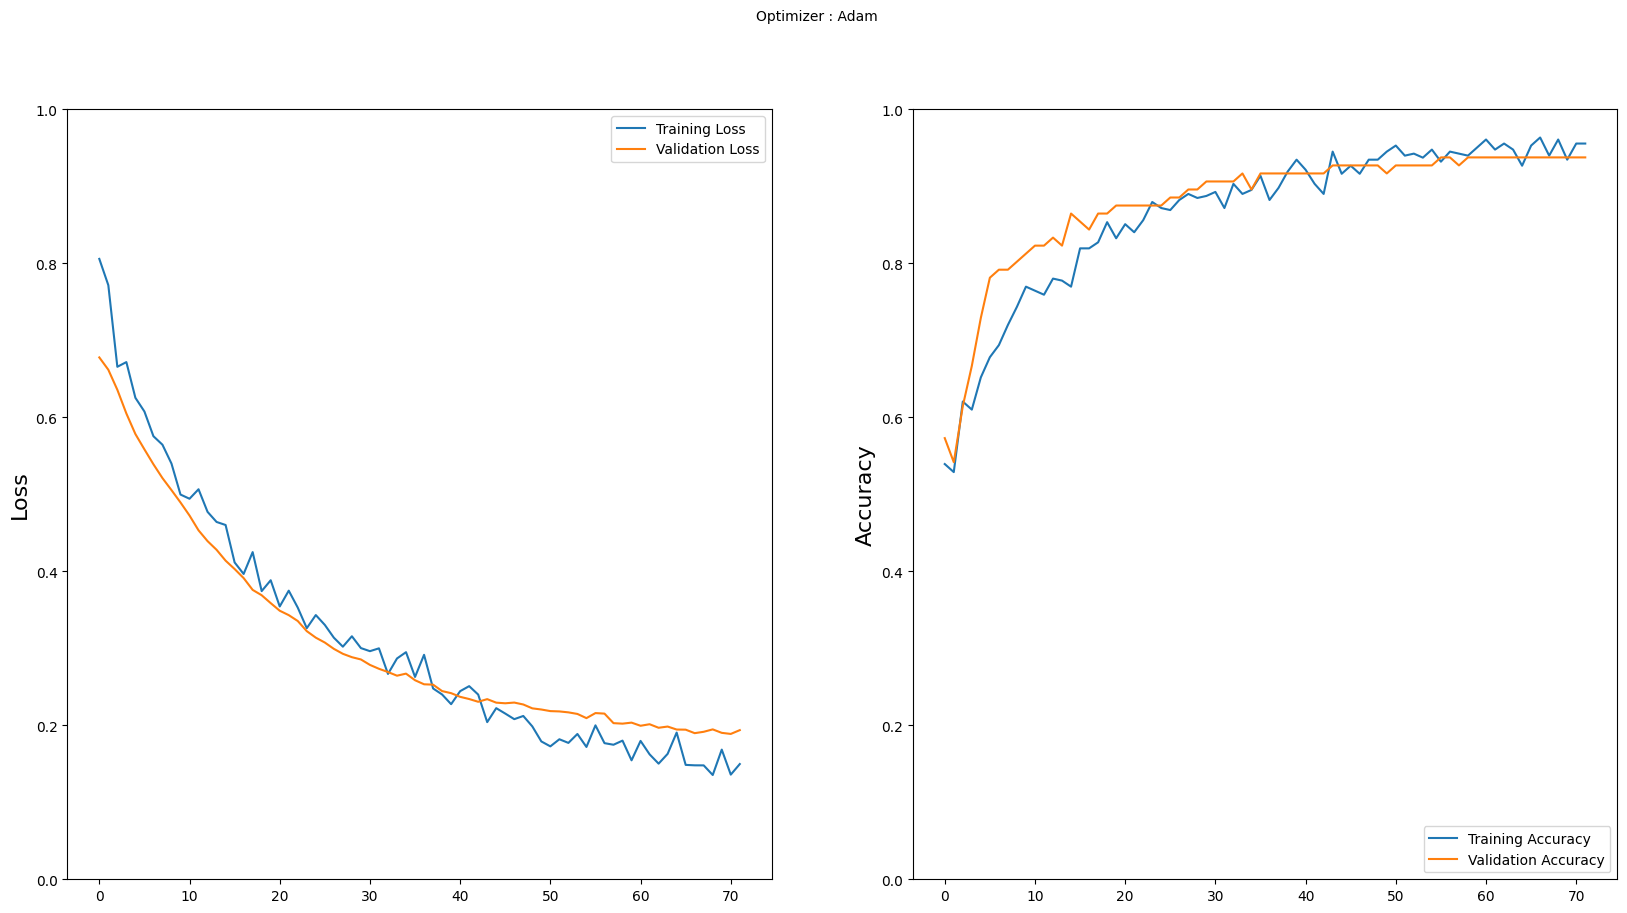

Fold 3/5
Found 382 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 868ms/step - accuracy: 0.4961 - loss: 0.8425 - val_accuracy: 0.5729 - val_loss: 0.6528
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.5179 - loss: 0.7794 - val_accuracy: 0.6458 - val_loss: 0.6282
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.5994 - loss: 0.6872 - val_accuracy: 0.6771 - val_loss: 0.6041
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - accuracy: 0.6311 - loss: 0.6309 - val_accuracy: 0.7396 - val_loss: 0.5799
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.6165 - loss: 0.6838 - val_accuracy: 0.7500 - val_loss: 0.5611
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.6700 - loss: 0.6176 - val_accuracy: 0.7812 - val_loss: 0.5419
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.6809 - loss: 0.5972 - val_accuracy: 0.8021 - val_loss: 0.5239
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.7247 - loss: 0.5597 - val_acc

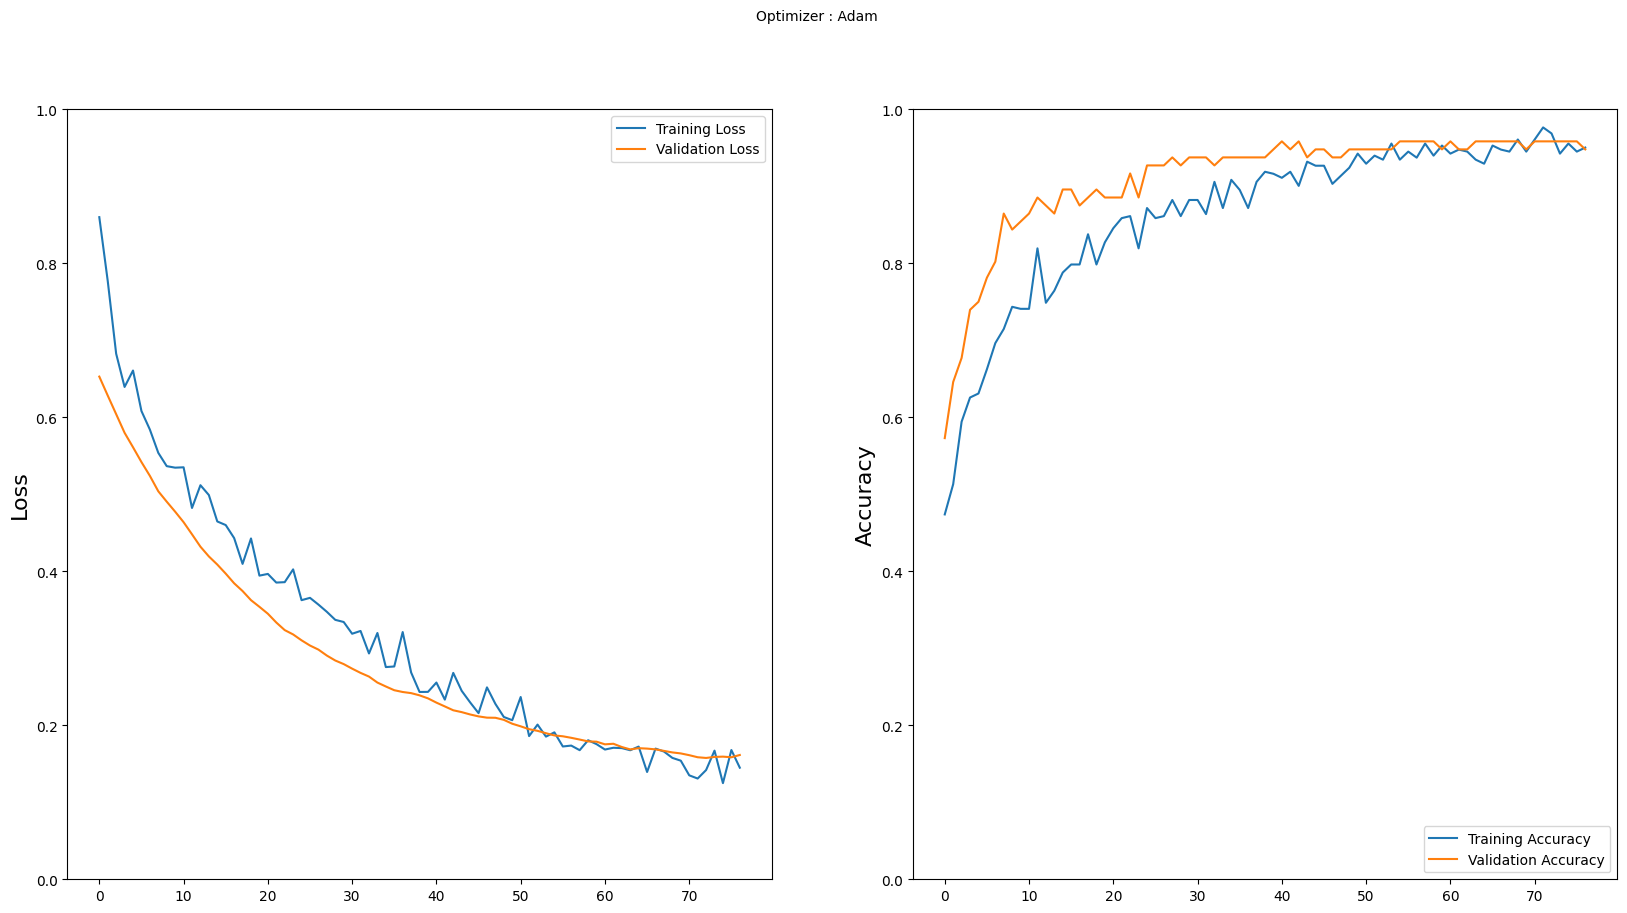

Fold 4/5
Found 383 validated image filenames belonging to 2 classes.
Found 95 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4789 - loss: 0.7856 - val_accuracy: 0.6842 - val_loss: 0.6386
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 0.5318 - loss: 0.7343 - val_accuracy: 0.7158 - val_loss: 0.5974
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.6406 - loss: 0.6478 - val_accuracy: 0.7684 - val_loss: 0.5719
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.6166 - loss: 0.6625 - val_accuracy: 0.8000 - val_loss: 0.5493
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.6213 - loss: 0.6465 - val_accuracy: 0.8211 - val_loss: 0.5273
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.6301 - loss: 0.6407 - val_accuracy: 0.8421 - val_loss: 0.5060
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.7283 - loss: 0.5560 - val_accuracy: 0.8211 - val_loss: 0.4892
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.6956 - loss: 0.5658 - val_accura

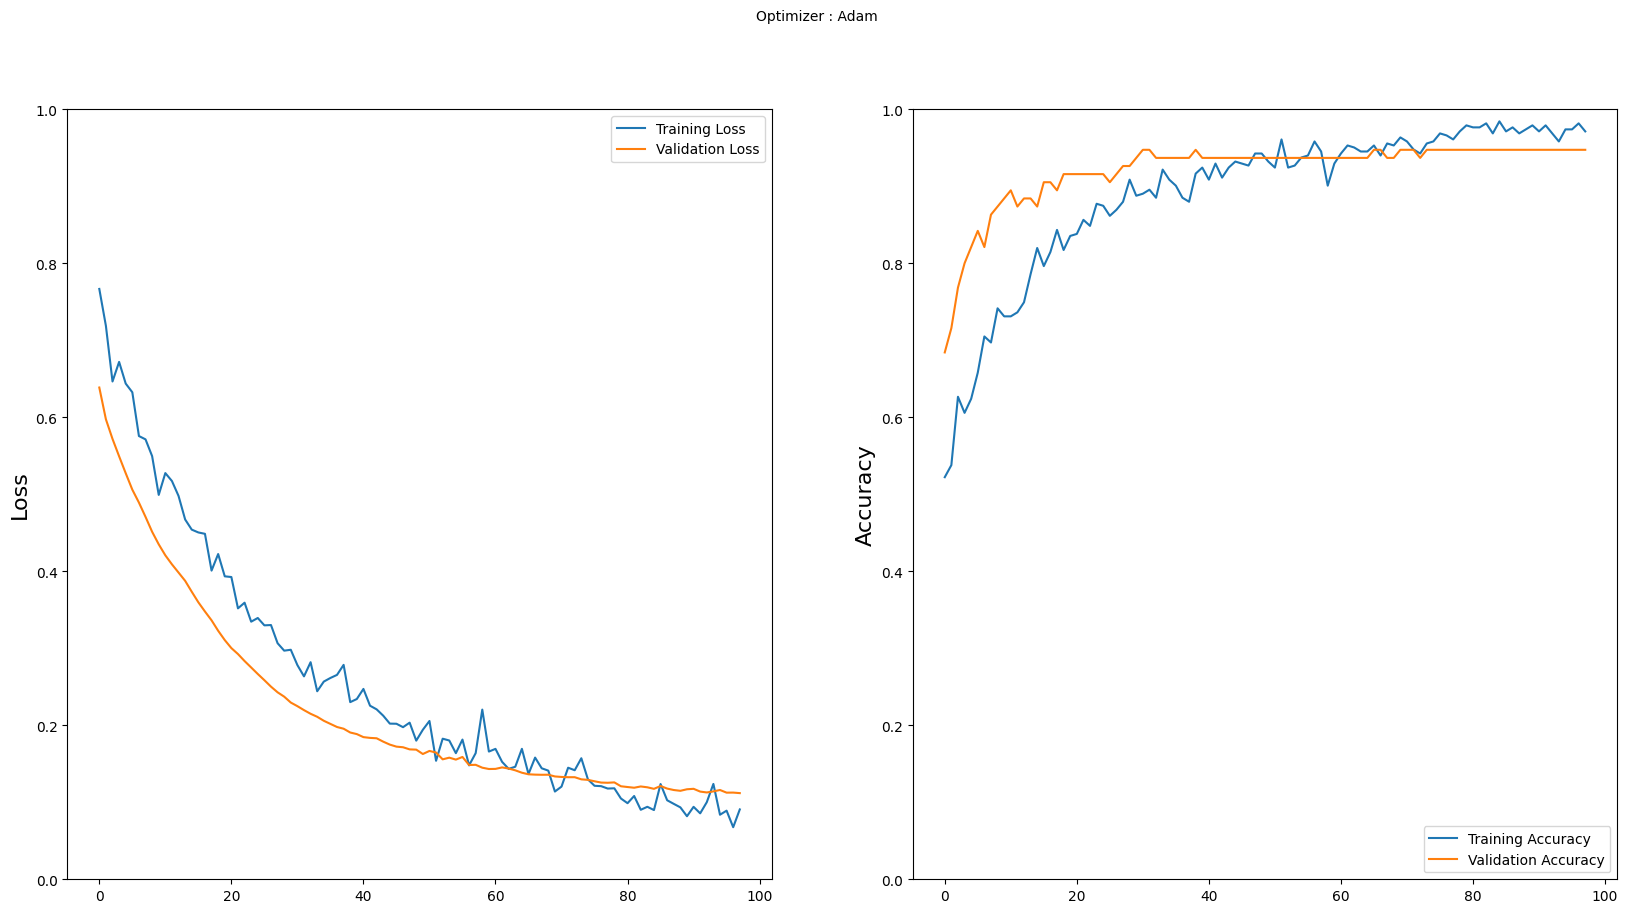

Fold 5/5
Found 383 validated image filenames belonging to 2 classes.
Found 95 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4476 - loss: 0.9522 - val_accuracy: 0.4842 - val_loss: 0.7326
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.5074 - loss: 0.8183 - val_accuracy: 0.4842 - val_loss: 0.6984
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.5426 - loss: 0.7195 - val_accuracy: 0.5579 - val_loss: 0.6772
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.4993 - loss: 0.7844 - val_accuracy: 0.6000 - val_loss: 0.6589
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.5335 - loss: 0.7237 - val_accuracy: 0.6316 - val_loss: 0.6466
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.5958 - loss: 0.6456 - val_accuracy: 0.7263 - val_loss: 0.6347
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.6156 - loss: 0.6473 - val_accuracy: 0.7579 - val_loss: 0.6252
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.6981 - loss: 0.5947 - val_accura

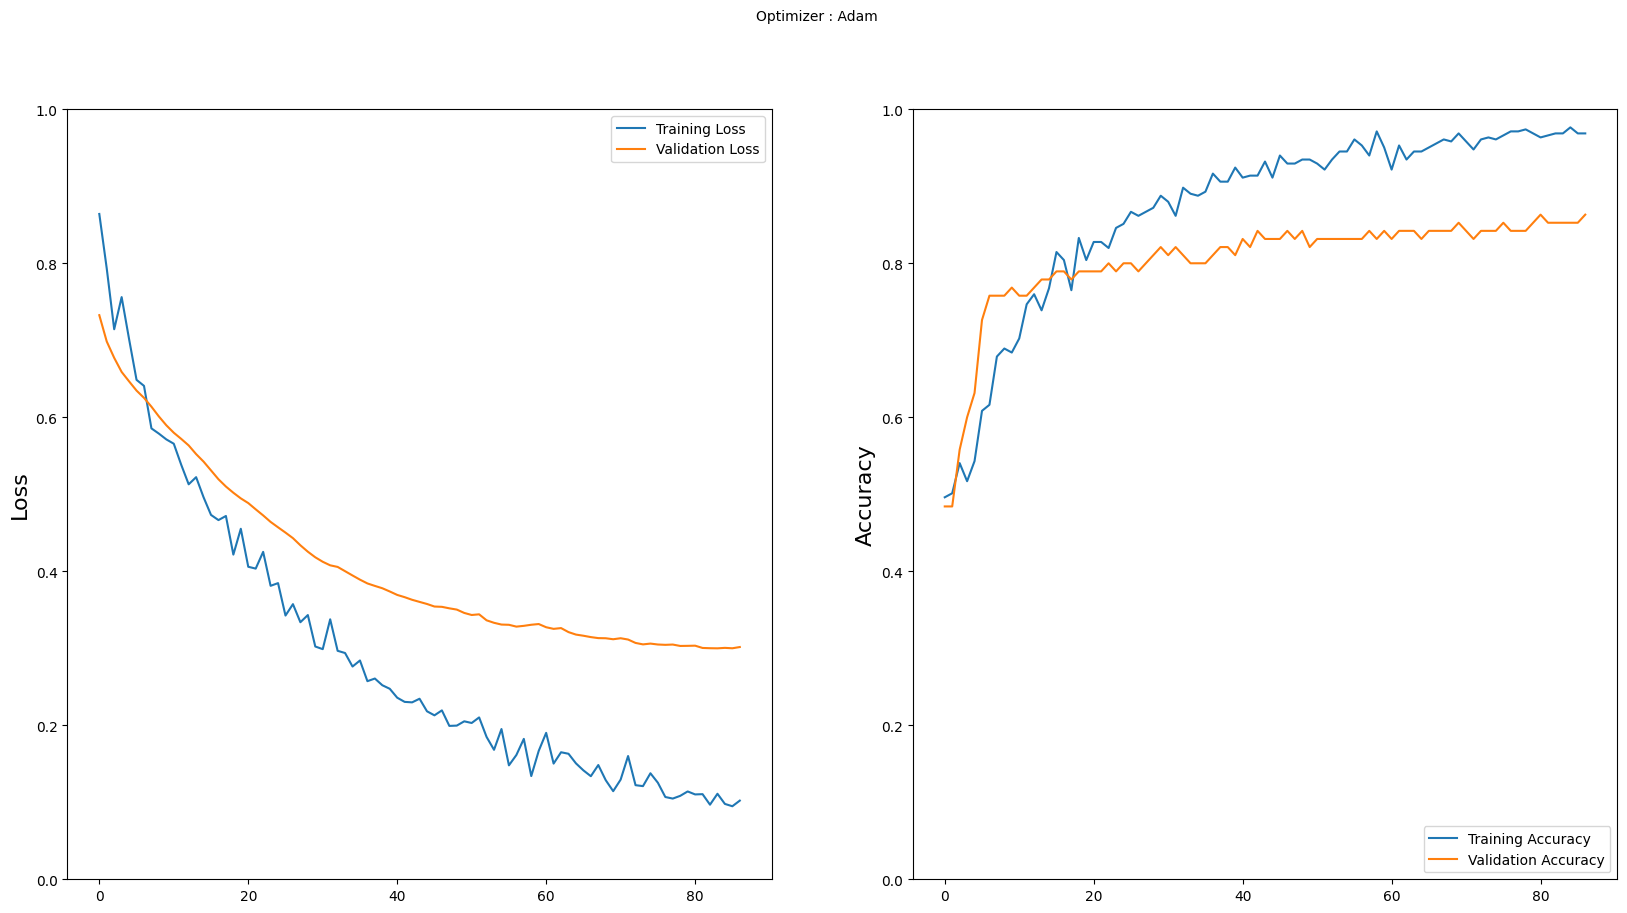

Moyenne des accuracies sur 5 folds: 0.9309


In [29]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (224, 224, 3)
batch_size = 32
epochs = 100
k_folds = 5
num_classes = 2

kf = KFold(n_splits=k_folds, shuffle=True, random_state=6)
fold_accuracies = []


image_dir = "/content/drive/My Drive/acrima/train"

for fold, (train_idx, val_idx) in enumerate(kf.split(df_balanced)):
    print(f'Fold {fold+1}/{k_folds}')


    train_df = df_balanced.iloc[train_idx]
    val_df = df_balanced.iloc[val_idx]


    train_generator = datagen.flow_from_dataframe(
        train_df,
        directory=image_dir,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="binary"
    )

    val_generator = datagen.flow_from_dataframe(
        val_df,
        directory=image_dir,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="binary"
    )

    model=create_model()




    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[early_stopping]
    )


    fold_accuracy = max(history.history['val_accuracy'])
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {fold+1} Accuracy: {fold_accuracy:.4f}")


    import matplotlib.pyplot as plt

    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.suptitle('Optimizer : Adam', fontsize=10)
    plt.ylabel('Loss', fontsize=16)
    plt.ylim([0, 1])


    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize=16)
    plt.ylim([0, 1])

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.show()

import numpy

print(f'Moyenne des accuracies sur {k_folds} folds: {numpy.mean(fold_accuracies):.4f}')


# Train the model

Everything is set up, let's train our model now!

Our best model managed to obtain a validation accuracy of approximately 65%, which is quite good given the fact that our target class has 7 possible values!

At each epoch, Keras checks if our model performed better than during the previous epochs. If it is the case, the new best model weights are saved into a file. This will allow us to load directly the weights of our model without having to re-train it if we want to use it.

We also have to save the structure of our CNN (layers etc.) into a file:

In [30]:
model.save('/content/drive/My Drive/glaucome_MobileNet.hdf5')
print("SAVED")

SAVED


# Analyze the results

We got outputs at each step of the training phase. All those outputs were saved into the 'history' variable. We can use it to plot the evolution of the loss and accuracy on both the train and validation datasets:

The validation accuracy starts to stabilize at the end of the 50 epochs between 60% and 65% accuracy.

The training loss is slightly higher than the validation loss for the first epochs which can be surprising. Indeed we are more used to see higher validation losses than training losses in machine learning. Here this is simply due to the presence of dropout, which is only applied during the training phase and not during the validation phase.

We can see that the training loss is becoming much smaller than the validation loss after the 20th epochs. This means that our model starts to overfit our training dataset after too much iterations. That is why the validation loss does not decrease a lot after. One solution consists in early-stopping the training of the model.

We could also use some different dropout values and performing data augmentation. Those methods were tested on this dataset, but they did not significantly increase the validation accuracy although they reduced the overfitting effect. Using them slightly increased the training duration of the model.

Finally we can plot the confusion matrix in order to see how our model classified the images:

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    directory='/content/drive/My Drive/acrima/test',
    target_size=(224, 224),
    batch_size=140,
    class_mode='binary',
    shuffle=False
)


Found 140 images belonging to 2 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
✅ Accuracy: 93.57%


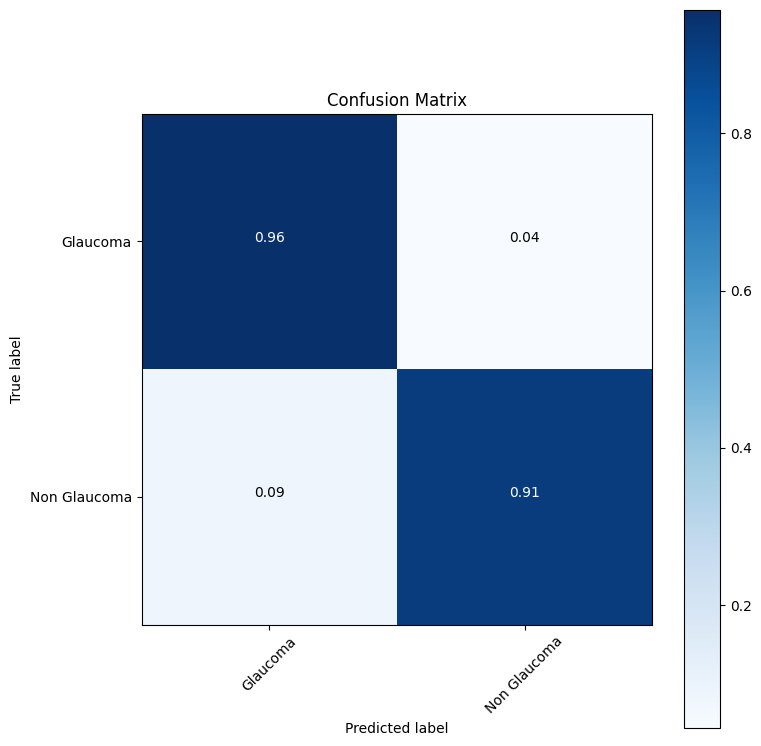

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalisation
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# 🔹 Prédictions et vraies étiquettes
predictions = model.predict(test_generator, verbose=1)
y_pred = (predictions > 0.5).astype(int).flatten()

y_true = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]
    y_true.extend(labels)

y_true = np.array(y_true).astype(int)

# 🔹 Matrice de confusion
cnf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
class_names = list(train_generator.class_indices.keys())

# 🔹 Affichage
print(f"✅ Accuracy: {accuracy * 100:.2f}%")
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
